In [1]:
import json
import sys
import os
from PIL import Image, ImageDraw

In [2]:
# import the library
root_dir = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.append(root_dir)

from svglib.svg import SVG
from svglib.geom import Point

In [3]:
sample_dir = os.path.join(root_dir, "samples")
coords = json.load(open(os.path.join(sample_dir, "placing.json")))  # a file that tells you where to place a series of SVGs in a canvas 

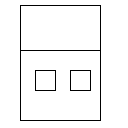

In [4]:
# draw the bounding boxes that tells where to place all the SVGs 
img = Image.new('RGB', (128, 128), color='white')
draw = ImageDraw.Draw(img)
for _, c in coords.items():
    x, y, x2, y2 = c['bounding_box']
    draw.rectangle([x, y, x2, y2], outline="black", fill=None)
img

In [18]:
# let's take the first square, and scale it to fit its bounding box in the canvas
def compute_scale_shift(x1, y1, x2, y2):
    orig_w, orig_h = (128, 128)  # the original size of the svg file
    new_w, new_h = (x2 - x1, y2 - y1)  # the size of the bounding box
    width_ratio = new_w / orig_w
    height_ratio = new_h / orig_h
    return min(width_ratio, height_ratio)

(x1, y1, x2, y2) = coords["house_body"]["bounding_box"]
scale_factor = compute_scale_shift(x1, y1, x2, y2)


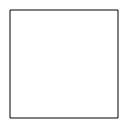

SVG[Bbox(0.0 0.0 128.0 128.0)](
	SVGLine(xy1=P(10.0, 10.0) xy2=P(118.0, 10.0)),
	SVGLine(xy1=P(118.0, 10.0) xy2=P(118.0, 118.0)),
	SVGLine(xy1=P(118.0, 118.0) xy2=P(10.0, 118.0)),
	SVGLine(xy1=P(10.0, 118.0) xy2=P(10.0, 10.0))
)

In [6]:
# display one SVG
svg_path = os.path.join(sample_dir, coords["house_body"]["file"])
svg = SVG.load_svg(svg_path)
svg.draw(do_display=True)
svg

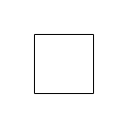

In [7]:
# let's scale 
svg.zoom(scale_factor)
svg.draw(do_display=True)


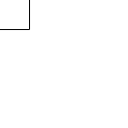

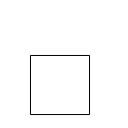

In [8]:
# let's adjust the shape so that the new center is the center of the bounding box
svg.translate(-svg.viewbox.center)
svg.draw(do_display=True)

target_center = Point((x1 + x2) // 2, (y1 + y2) // 2)
svg.translate(target_center)
svg.draw(do_display=True)


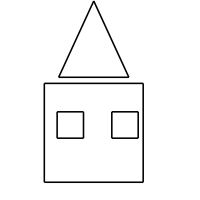

In [17]:
# apply this to every shape in the SVG file
composite = SVG([], (128, 128), width=128, height=128)

for shape in coords.values():
    svg_path = os.path.join(sample_dir, shape["file"])
    svg = SVG.load_svg(svg_path)
    
    (x1, y1, x2, y2) = shape["bounding_box"]
    scale_factor = compute_scale_shift(x1, y1, x2, y2)
    target_center = Point((x1 + x2) // 2, (y1 + y2) // 2)
    
    svg.zoom(scale_factor)
    svg.translate(-svg.viewbox.center)
    svg.translate(target_center)
    composite = composite + svg 
    
composite.draw(do_display=True)

In [10]:
SVG([], (128, 128), width=128, height=128)

SVG[Bbox(0.0 0.0 128.0 128.0)](

)

In [ ]:
def merge_svg_files(coordinates, file_dir):
    image_size = (128, 128)  # Original image dimensions (width, height)
    for key, coords in coordinates.items():
        file = coords["file"]
        (x1, y1, x2, y2) = coords["bounding_box"]
        width_ratio = (x2 - x1) / image_size[0]
        height_ratio = (y2 - y1) / image_size[1]
        assert width_ratio == height_ratio, "Width and height ratios should be equal."

        svg = SVG.load_svg(os.path.join(file_dir, file))
        svg.zoom(width_ratio)
        
        from svglib.geom import Point
        target_center = Point(x1, y1)
        svg.translate(target_center)

        svg.save_svg(os.path.join(file_dir, "out.svg"))

In [13]:
# test
composite.bbox()

NotImplementedError: 